This Kernel for someone want to deep dive into image classification. I use CNN for classification model. If you found this Kernel helpful please up vote it. If you have some feedback and question don't forget to comment below. 

I have simplier model with 
* https://www.kaggle.com/uysimty/get-start-image-classification

# Import Library

In [1]:
import numpy as np
import pandas as pd 
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
#print(os.listdir("../input"))


Using TensorFlow backend.
/home/cu/anaconda3/envs/es/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cu/anaconda3/envs/es/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cu/anaconda3/envs/es/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cu/anaconda3/envs/es/lib/python3.6/sit

# Define Constants

In [2]:
FAST_RUN = False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# parameters for optimizers
lr = 1e-3

# Parameters for training
epochs = 25
batch_size = 8

# parameters for callback functions
es_patience = 10
rlrop_patience = 5
decay_rate = 0.5

input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
TRAIN_PATH="/home/cu/datasets/cats_and_dogs/train/"
TEST_PATH="/home/cu/datasets/cats_and_dogs/test/"

# Prepare Traning Data

filenames = os.listdir("../input/")
print(filenames)

#압축을 풀어준다.
import zipfile
myzip = zipfile.ZipFile('../input/train.zip')
myzip.extractall('/kaggle/working')
myzip.close()

In [3]:
filenames = os.listdir(TRAIN_PATH)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head()

,filename,category
0,cat.11037.jpg,0
1,dog.9498.jpg,1
2,cat.2992.jpg,0
3,cat.7665.jpg,0
4,dog.2466.jpg,1


In [ ]:
df.tail()

### See Total In count

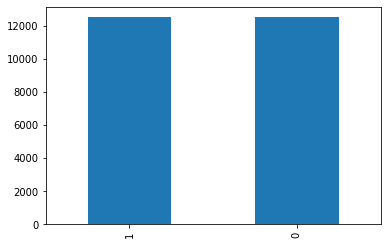

In [6]:
df['category'].value_counts().plot.bar()

![](http://)From our data we have 12500 cats and 12500 dogs

# See sample image

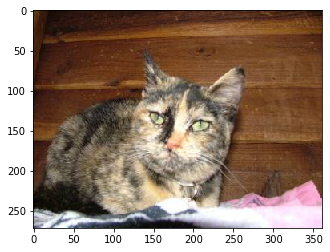

In [7]:
sample = random.choice(filenames)
image = load_img(TRAIN_PATH+sample)
plt.imshow(image)

# Build Model

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D

import efficientnet.keras as efn 
n_classes = 2

efnb0 = efn.EfficientNetB3(weights = 'imagenet', include_top = False, classes = n_classes, input_shape = input_shape)

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation = 'softmax'))

model.summary()

Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
44113920/44107200 [==============================] - 29s 1us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 7, 7, 1536)        10783528  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3074      
Total params: 10,786,602
Trainable params: 10,699,306
Non-trainable params: 87,296
_________________________________________________________________


In [9]:
sgd = SGD(lr = lr, momentum = 0.9, nesterov = True)
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = es_patience, restore_best_weights = True, verbose = 1)
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = rlrop_patience, 
                        factor = decay_rate, min_lr = 1e-6, verbose = 1)

In [10]:
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['acc'])

# Callbacks

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [12]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [14]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification. 

So we will convert 1 to dog and 0 to cat

In [15]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [16]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

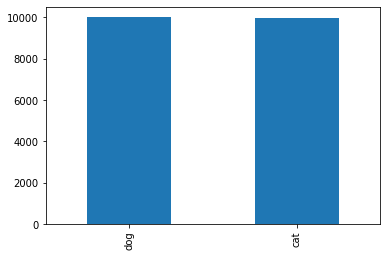

In [17]:
train_df['category'].value_counts().plot.bar()

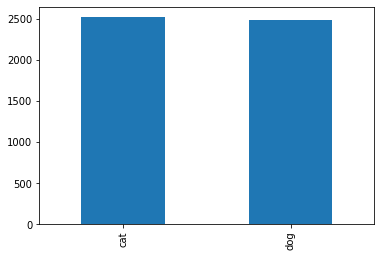

In [18]:
validate_df['category'].value_counts().plot.bar()

In [19]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=16
num_epochs=8

# Traning Generator

In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation Generator

In [21]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


# See how our generator work

In [22]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


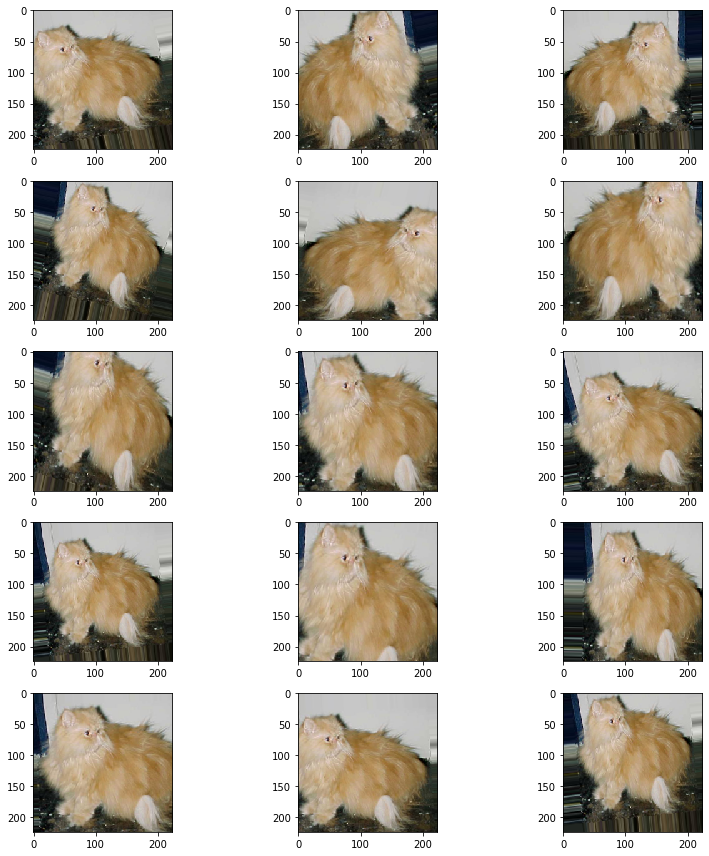

In [23]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice 

# Fit Model

In [24]:
epochs=3 if FAST_RUN else num_epochs
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/8
1250/1250 [==============================] - 284s 227ms/step - loss: 0.1562 - acc: 0.9381 - val_loss: 0.0414 - val_acc: 0.9876
Epoch 2/8
1250/1250 [==============================] - 276s 221ms/step - loss: 0.0764 - acc: 0.9713 - val_loss: 0.0301 - val_acc: 0.9898
Epoch 3/8
1250/1250 [==============================] - 276s 221ms/step - loss: 0.0561 - acc: 0.9797 - val_loss: 0.0262 - val_acc: 0.9912
Epoch 4/8
1250/1250 [==============================] - 276s 221ms/step - loss: 0.0432 - acc: 0.9842 - val_loss: 0.0248 - val_acc: 0.9916
Epoch 5/8
1250/1250 [==============================] - 277s 221ms/step - loss: 0.0339 - acc: 0.9879 - val_loss: 0.0223 - val_acc: 0.9914
Epoch 6/8
1250/1250 [==============================] - 276s 221ms/step - loss: 0.0304 - acc: 0.9897 - val_loss: 0.0201 - val_acc: 0.9924
Epoch 7/8
1250/1250 [==============================] - 276s 221ms/step - loss: 0.0239 - acc: 0.9918 - val_loss: 0.0213 - val_acc: 0.9920
Epoch 8/8
1250/1250 [====================

# Save Model

In [25]:
model.save_weights("model.h5")

# Virtualize Training

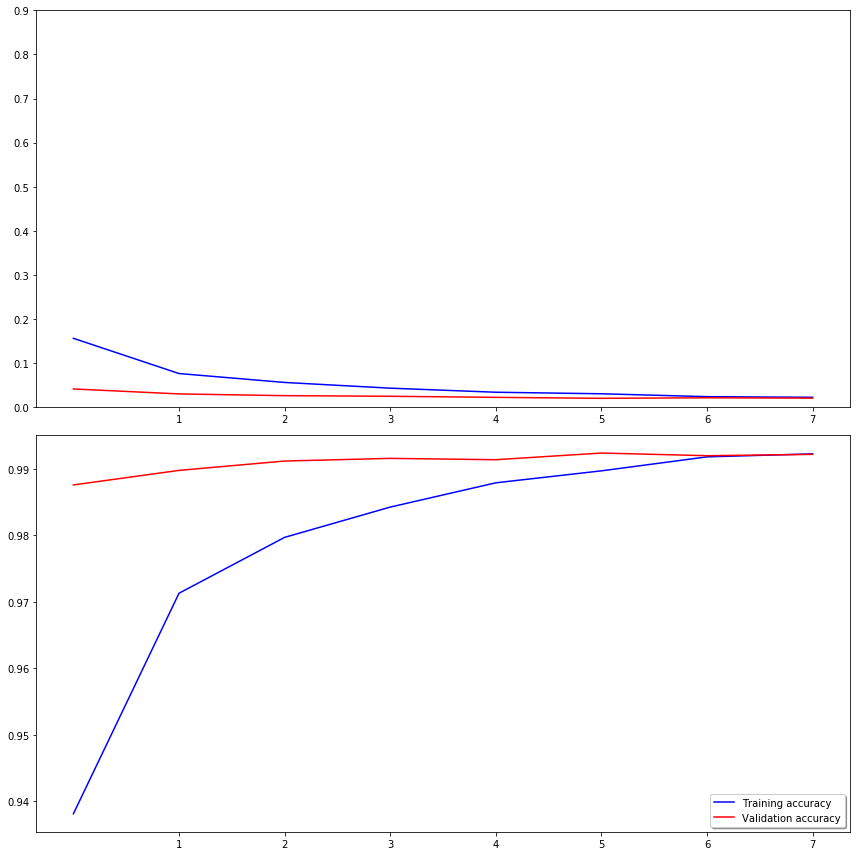

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [28]:
test_filenames = os.listdir(TEST_PATH)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [29]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    TEST_PATH, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


# Predict

In [30]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [31]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using `train_generator.class_indices`. It is the classes that image generator map while converting data into computer vision

In [32]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with `{1: 'dog', 0: 'cat'}`. Now we will map the result back to dog is 1 and cat is 0

In [33]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

### Virtaulize Result

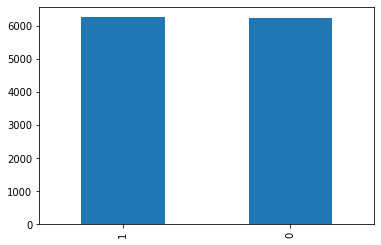

In [34]:
test_df['category'].value_counts().plot.bar()

### See predicted result with images

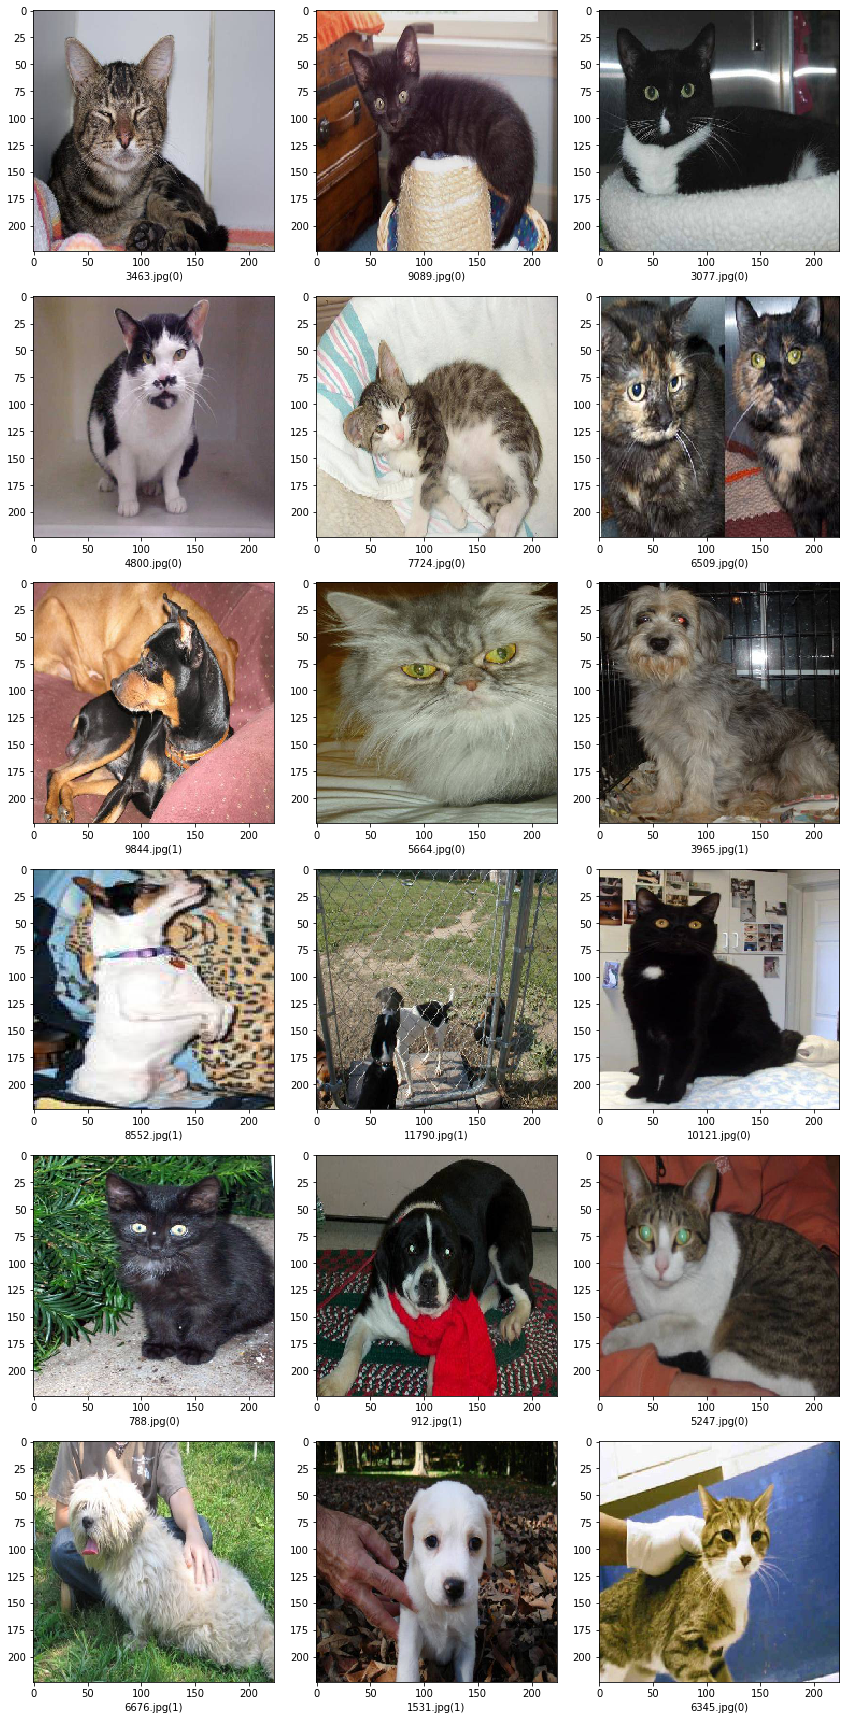

In [35]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(TEST_PATH+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Submission

In [36]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

In [45]:
img_path = '/home/cu/datasets/cats_and_dogs/test/16.jpg'

# 이미지를 4D 텐서로 변경합니다
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# 모델이 훈련될 때 입력에 적용한 전처리 방식을 동일하게 사용합니다
img_tensor /= 255.

# 이미지 텐서의 크기는 (1, 150, 150, 3)입니다
print(img_tensor.shape)

(1, 150, 150, 3)


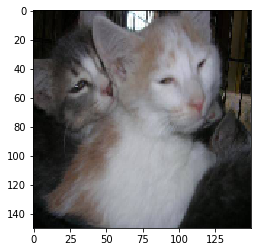

In [46]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [52]:
from keras import models

# 상위 8개 층의 출력을 추출합니다:
layer_outputs = [layer.output for layer in model.layers[:8]]
# 입력에 대해 8개 층의 출력을 반환하는 모델을 만듭니다:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

AttributeError: Layer efficientnet-b3 has multiple inbound nodes, hence the notion of "layer output" is ill-defined. Use `get_output_at(node_index)` instead.